In [1]:
import os 
import getpass
from dotenv import load_dotenv

## retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores.base import VectorStoreRetriever

## tool
from langgraph.prebuilt import ToolExecutor
from langchain.tools.retriever import create_retriever_tool

## agent
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

## Nodes and Edges
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser

## Graph
from langgraph.graph import END, StateGraph

## Response
import pprint
from langchain_core.messages import HumanMessage



# from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
# 
# from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
# from langchain.tools.render import format_tool_to_openai_function
# from langgraph.graph import END, StateGraph

c:\Users\ghckd\anaconda3\envs\voltai\Lib\site-packages\IPython\core\interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## API Key Setting

In [2]:
def _set_if_undefined(var: str):
    # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


# OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("OPENAI_API_KEY")
# LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
input_data = "../참고논문_1.pdf"

## retriever(검색기) 생성

In [4]:
def embedding_file(file: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다. 

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기 
    """
    
    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(       
        chunk_size=500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )
    
    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file}")
    docs = loader.load_and_split(text_splitter=splitter)
    
    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )
    
    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity"    ## 어떻게 검색할 것인지? default가 유사도
    )

    return retriever

In [5]:
retriever = embedding_file(file=input_data)

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)


In [20]:
from langchain_teddynote.messages import messages_to_history
from langchain_core.documents.base import Document
# from rag.utils import format_docs

def format_docs(docs: list[Document]) -> str:
    """문시 리스트에서 텍스트를 추출하여 하나의 문자로 합치는 기능을 합니다. 

    Args:
        docs (list[Document]): 여러 개의 Documnet 객체로 이루어진 리스트

    Returns:
        str: 모든 문서의 텍스트가 하나로 합쳐진 문자열을 반환
    """
    return "\n\n".join(doc.page_content for doc in docs)

# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # prompt 설정
    prompt = PromptTemplate(
        template="""
        Based on the following document, please provide an answer to the given question.

        Document:
        {context}

        Question:
        {question}

        Answer:
        """,
        input_variables=["context", "question"],
        )
    
    # llm 호출
    llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0, 
        streaming=True
        )
    
    # 체인 호출
    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, 
        messages=[("user", latest_question), ("assistant", response)]
    )

In [21]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)


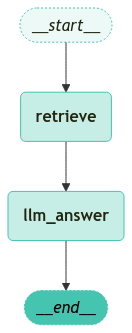

In [22]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [23]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="논문을 요약해줘")

In [24]:
# 그래프 실행
stream_graph(
    graph=app, 
    inputs=inputs, 
    config=config, 
    node_names=["llm_answer"]
)
outputs = app.get_state(config).values


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
이 논문은 NCM622 (LiNi₀.₆Co₀.₂Mn₀.₂O₂) 양극 물질의 주기적 안정성을 개선하기 위한 새로운 구조 설계에 관한 연구를 다루고 있습니다. 연구진은 다중 껍질 구조의 중공 필름을 가진 NCM622 양극 물질을 개발하여, 리튬 이온 배터리의 충전 및 방전 과정에서 발생하는 강한 계면 반응을 줄이고, 물질의 구조적 불안정을 완화하는 데 성공했습니다. 이 구조는 이온 및 전자 전송을 위한 상호 연결된 전도성 네트워크를 제공하여, 100회 주기 후에도 90.4%의 용량 유지율을 달성했습니다. 연구는 또한 NCM622 양극 물질의 전기화학적 성능을 향상시키기 위한 구조 설계 전략의 가능성을 제시하며, 이 물질이 리튬 이온 배터리의 양극 물질로서의 잠재력을 가지고 있음을 보여줍니다.